In [1]:
import h5py
import pickle 
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

import cca.kron_pca
from cca.data_util import sum_over_chunks, get_active_channels, sliding_z_score, calc_autocorr_fns, cv_decoding_score
from cca import ComplexityComponentsAnalysis

In [2]:
def cca_pca(N, T, cross_cov_mats, min_dim=1, max_dim=None, skip=1, num_reps=1):
    opt = ComplexityComponentsAnalysis(T=T, init="random_ortho", device=None, use_scipy=True)
    opt.cross_covs = cross_cov_mats
    
    w, V = scipy.linalg.eigh(cross_cov_mats[0])
    w, V = w[::-1], V[:, ::-1]
    
    if max_dim is None:
        max_dim = N
        
    dim_vals = np.arange(min_dim, max_dim+1, skip)
    cca_pi_vals = np.zeros((len(dim_vals), num_reps))
    pca_pi_vals = np.zeros(len(dim_vals))
    V_set = []
    
    for dim_idx in range(len(dim_vals)):
        opt_dim = dim_vals[dim_idx]
        V_set_for_dim = []
        for rep_idx in range(num_reps):
            print("rep =", rep_idx+1)
            opt.fit_projection(d=opt_dim)
            V_set_for_dim.append(opt.coef_)
            cca_pi = opt.score()
            cca_pi_vals[dim_idx, rep_idx] = cca_pi
        V_set.append(V_set_for_dim)
        opt.coef_ = V[:, :opt_dim]
        pca_pi = opt.score()
        pca_pi_vals[dim_idx] = pca_pi
        
        print(opt_dim, cca_pi, pca_pi)
        
    return dim_vals, cca_pi_vals, pca_pi_vals, V_set

In [74]:
bin_width_s = .100

def load_sabes_data():
    f = h5py.File("/home/davidclark/Projects/DataUtil/nhp_reaches_sorted.hdf5", "r")
    sessions = list(f.keys())
    lengths = np.array([f[session]["M1"]["spikes"].shape[0] for session in sessions])
    session = sessions[np.argsort(lengths)[::-1][0]] #longest session
    X, Y = f[session]["M1"]["spikes"], f[session]["cursor"]
    chunk_size = int(bin_width_s / .004)
    X, Y = sum_over_chunks(X, chunk_size), sum_over_chunks(Y, chunk_size)
    return X, Y

def load_miller_data():
    file = open("/home/davidclark/Desktop/KordingData/example_data_m1.pickle", "rb")
    data = pickle.load(file)
    X, Y = data[0], data[1]
    chunk_size = int(bin_width_s / .05)
    X, Y = sum_over_chunks(X, chunk_size), sum_over_chunks(Y, chunk_size)
    return X, Y

X, Y = load_sabes_data()

In [75]:
window_size_s = 60
window_size_bins = int(window_size_s / bin_width_s)
min_spikes_in_window = 30
active_channels = get_active_channels(X, window_size_bins, min_spikes_in_window)
N = np.sum(active_channels)
print(str(N) + " active channels (" + str(np.round(100 * N/X.shape[1], 2)) + "%)")

X_active = X[:, active_channels]
X_sqrt = np.sqrt(X_active)
X_z_score = sliding_z_score(X_sqrt, window_size_bins)

113 active channels (29.43%)


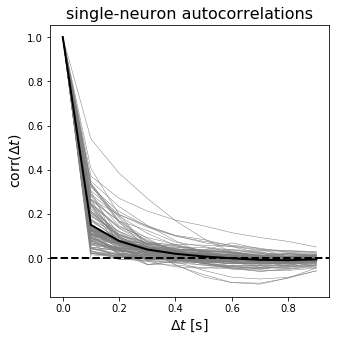

In [76]:
T = 10

autocorr_fns = calc_autocorr_fns(X_z_score, T)
t = np.arange(T)*bin_width_s

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(t, autocorr_fns.T, c="gray", linewidth=0.5)
ax.plot(t, autocorr_fns.mean(axis=0), c="black", linewidth=2)
ax.axhline(0, c="black", linestyle="--", linewidth=2)

ax.set_xlabel("$\Delta t$ [s]", fontsize=14)
ax.set_ylabel("corr$(\Delta t)$", fontsize=14)
ax.set_title("single-neuron autocorrelations", fontsize=16)

plt.show()

In [77]:
X_lags = cca.kron_pca.form_lag_matrix(X_z_score, T)
cov = np.dot(X_lags.T, X_lags)/len(X_lags)
cov_toep = cca.kron_pca.toeplitzify(cov, X_z_score.shape[1], T)
w = scipy.linalg.eigvalsh(cov_toep)
print("Minimum Toeplitz covariance eigenvalue = " + str(np.min(w)))

Minimum Toeplitz covariance eigenvalue = 0.33797200501834834


In [102]:
r_vals = np.array([2*T - 1])
sigma_vals = np.linspace(1., 2*T, 10)
alpha_vals = np.linspace(0.05, 1., 10)
ll_vals, opt_idx = cca.kron_pca.cv_toeplitz(X_lags, N, T, r_vals, sigma_vals, alpha_vals, num_folds=3)
opt_r, opt_sigma, opt_alpha = r_vals[opt_idx[0]], sigma_vals[opt_idx[1]], alpha_vals[opt_idx[2]]

opt_r, opt_sigma, opt_alpha

fold = 1
r = 19
fold = 2
r = 19
fold = 3
r = 19


(19, 5.222222222222222, 0.2611111111111111)

In [104]:
opt_r, opt_sigma, opt_alpha = (19, 5.222222222222222, 0.2611111111111111)

cov_reg = cca.kron_pca.toeplitz_reg_taper_shrink(cov, N, T, opt_r, opt_sigma, opt_alpha)
cross_cov_mats = cca.cov_util.calc_cross_cov_mats_from_cov(N, T, cov_reg)

In [17]:
T_pi_vals = np.array([3]) #np.arange(T_pi) + 1
all_pi_vals = []

for T_pi_sub_idx in range(len(T_pi_vals)):
    T_pi_sub = T_pi_vals[T_pi_sub_idx]
    cross_cov_mats_sub = cross_cov_mats[:2*T_pi_sub, :, :]
    dim_vals, cca_pi_vals, pca_pi_vals, V_set = cca_pca(N, 2*T_pi_sub, cross_cov_mats_sub,
                                                    min_dim=1, max_dim=N,
                                                    skip=10, num_reps=1)
    all_pi_vals.append(cca_pi_vals)






rep = 1
1 1.5160772276478307 0.829174278777155
rep = 1
11 7.650035575904407 6.428099907039326
rep = 1
21 9.954476114948246 8.19368892135578
rep = 1
31 11.380287451243777 8.913961009867963
rep = 1
41 12.373947250210795 9.445095436987186
rep = 1
51 13.11947091462016 10.02352342370438
rep = 1
61 13.672816599120049 10.559101963185961
rep = 1


KeyboardInterrupt: 

No handles with labels found to put in legend.


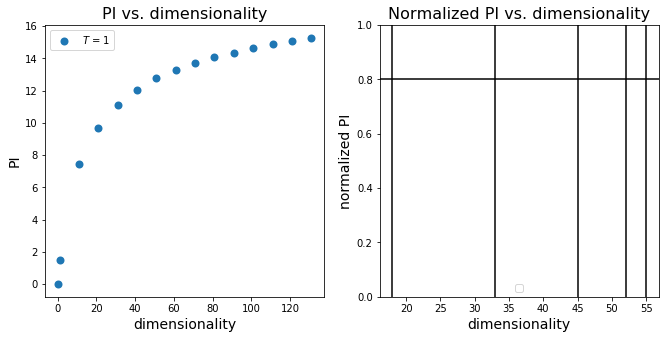

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5))
ax1, ax2 = axes.flatten()
x = np.array([0] + list(dim_vals))

for T_idx in range(len(T_pi_vals)):
    
    pi = all_pi_vals[T_idx].flatten()
    y = np.array([0] + list(pi))
    #y /= np.max(y)
    #y = y[1:]-y[:-1]
    ax1.scatter(x, y, label="$T$ = " + str(T_idx+1), linewidth=2)
    #ax2.plot(x, y/np.max(y), label="$T$ = " + str(T_idx+1), linewidth=2)

#ax1.plot(x, [0] + list(pca_pi_vals))
    
ax1.set_xlabel("dimensionality", fontsize=14)
ax1.set_ylabel("PI", fontsize=14)
ax1.set_title("PI vs. dimensionality", fontsize=16)

ax2.set_xlabel("dimensionality", fontsize=14)
ax2.set_ylabel("normalized PI", fontsize=14)
ax2.set_title("Normalized PI vs. dimensionality", fontsize=16)
ax2.legend()

ax2.axhline(0.8, c="black")

ax2.axvline(18, c="black")
ax2.axvline(33, c="black")
ax2.axvline(45, c="black")
ax2.axvline(52, c="black")
ax2.axvline(55, c="black")


ax1.legend()

#plt.savefig("nhp_figs/pivsdim.pdf", bbox_inches="tight")

    

In [110]:
opt = ComplexityComponentsAnalysis(T=T, init="random_ortho", device=None, use_scipy=True)
opt.cross_covs = cca.cov_util.calc_cross_cov_mats_from_cov(N, T, cov_toep)
w, V_pca = scipy.linalg.eigh(np.cov(X_z_score.T))
w, V_pca = w[::-1], V_pca[:, ::-1]

d_vals = np.arange(3, 20)
scores_pca, scores_dca = np.zeros(len(d_vals)), np.zeros(len(d_vals))
for d_idx in range(len(d_vals)):
    d = d_vals[d_idx]
    print(d)
    opt.fit_projection(d=d)
    V_dca = opt.coef_
    score_pca = cv_decoding_score(np.dot(X_z_score, V_pca[:, :d]), Y, num_folds=5, method="kf")
    score_dca = cv_decoding_score(np.dot(X_z_score, V_dca), Y, num_folds=5, method="kf")
    scores_pca[d_idx]= score_pca
    scores_dca[d_idx]= score_dca

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


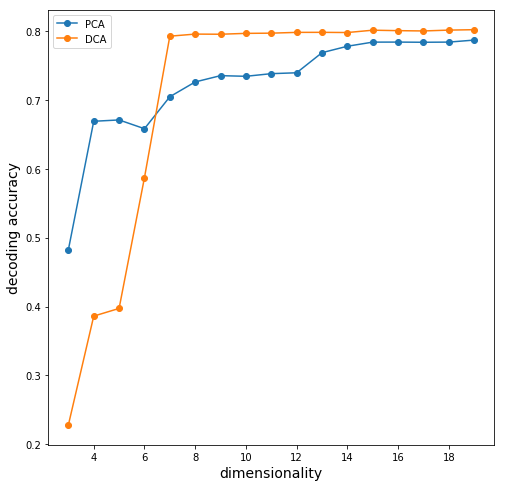

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(d_vals, scores_pca, label="PCA", marker="o")
ax.plot(d_vals, scores_dca, label="DCA", marker="o")
ax.set_xlabel("dimensionality", fontsize=14)
ax.set_ylabel("decoding accuracy", fontsize=14)
plt.legend()

In [21]:
Y.shape

(12649, 2)